# C&C final

In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from fet.common import convert_times
from fet.explorer import Explorer
from fet.pstats import extract_features, aggregate, swap_directions

pd.plotting.register_matplotlib_converters()

## Prepare and merge datasets

In [2]:
base_path = '/srv/data/uhricdan/data/magic'

In [3]:
my_cnc_datasets = glob.glob(f'{base_path}/cnc/**/*.csv')

iot_23_cnc_datasets = glob.glob(f'{base_path}/iot-23/cnc/*.csv')

iot_23_benign_datasets = glob.glob(f'{base_path}/iot-23/benign/*.csv')

unsw_benign_datasets = [
    f'{base_path}/iottraces/16-09-26/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-27/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-28/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-29/pstats.filter.csv',
    f'{base_path}/iottraces/16-09-30/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-01/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-02/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-03/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-04/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-05/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-06/pstats.filter.csv',
    f'{base_path}/iottraces/16-10-07/pstats.filter.csv'
]

cesnet_captures_datasets = glob.glob(f'{base_path}/cesnet/*.agg.csv')

In [4]:
def preprocess(df, swap_prefix, rename=True, swap=True):
    if rename:
        df.rename(columns=lambda x: x.split()[1].lower(), inplace=True)
        
    convert_times(df, inplace=True)
    
    if swap:
        swap_directions(df, df['dst_ip'].str.startswith(swap_prefix), inplace=True)
        
    df = aggregate(df)
    return df

My C&C dataset.

In [5]:
my_cnc = pd.DataFrame()

for f in my_cnc_datasets:
    my_cnc = my_cnc.append(pd.read_csv(f), ignore_index=True)
    
my_cnc = preprocess(my_cnc, '10.0.42.155')

IoT-23 C&C dataset.

In [6]:
iot_23_cnc = pd.DataFrame()

for f in iot_23_cnc_datasets:
    iot_23_cnc = iot_23_cnc.append(pd.read_csv(f), ignore_index=True)
    
iot_23_cnc = preprocess(iot_23_cnc, '192.168.')

IoT-23 benign dataset.

In [7]:
iot_23_benign = pd.DataFrame()

for f in iot_23_benign_datasets:
    iot_23_benign = iot_23_benign.append(pd.read_csv(f), ignore_index=True)
    
iot_23_benign = preprocess(iot_23_benign, '192.168.')

UNSW dataset.

In [8]:
unsw_benign = pd.DataFrame()

for f in unsw_benign_datasets:
    unsw_benign = unsw_benign.append(pd.read_csv(f), ignore_index=True)

unsw_benign = preprocess(unsw_benign, '192.168.', rename=False)

CESNET captures dataset.

In [9]:
cesnet_benign = pd.DataFrame()

for f in cesnet_captures_datasets:
    print(f)
    cesnet_benign = cesnet_benign.append(pd.read_csv(f), ignore_index=True)
    
cesnet_benign = preprocess(cesnet_benign, 'X', swap=False)

/srv/data/uhricdan/data/magic/cesnet/p80.agg.csv
/srv/data/uhricdan/data/magic/cesnet/p8080.agg.csv
/srv/data/uhricdan/data/magic/cesnet/p20-21-25-143-3389.agg.csv
/srv/data/uhricdan/data/magic/cesnet/p443.agg.csv
/srv/data/uhricdan/data/magic/cesnet/p80-2.agg.csv
/srv/data/uhricdan/data/magic/cesnet/others.agg.csv
/srv/data/uhricdan/data/magic/cesnet/p22.agg.csv
/srv/data/uhricdan/data/magic/cesnet/p443-2.agg.csv


Labels.

In [10]:
my_cnc['label'] = 'cnc'
iot_23_cnc['label'] = 'cnc'
iot_23_benign['label'] = 'benign'
unsw_benign['label'] = 'benign'
cesnet_benign['label'] = 'benign'

Concat.

In [11]:
df = pd.concat([my_cnc, iot_23_cnc, iot_23_benign, unsw_benign, cesnet_benign])

Fix aggregation mismatch.

In [119]:
def cesnet_fix(x):
    x = x.strip('[]').split('|')
    x = [str(int(y)) for y in x if y != '']
    return '[' + '|'.join(x) + ']'

df.loc[:, ['ppi_pkt_lengths']] = df['ppi_pkt_lengths'].apply(lambda x: cesnet_fix(x))
df.loc[:, ['ppi_pkt_flags']] = df['ppi_pkt_flags'].apply(lambda x: cesnet_fix(x))

Remove flows w/ duration less then 30 seconds.

In [13]:
df = df[df['duration'] > 30.]

No length flows.

In [14]:
df = df[(df['ppi_pkt_lengths'] != '[]')]

Extract features.

In [15]:
df['label'].value_counts()

benign    147374
cnc         1896
Name: label, dtype: int64

In [16]:
(df['label'] == 'cnc').sum() / (df['label'] == 'benign').sum()

0.012865227244968584

In [22]:
e = Explorer(y='label')
e.fit(df, module='pstats')

Remove collerated features.

In [ ]:
e.remove_features(
    [
        'bytes_rev_rate',
        'bytes_total_rate',
        'packets_rate',
        'packets_rev_rate',
        'pkt_iat_max',
        'urg_ratio',
        'urg_count'
    ]
)

## GridSearchCV

In [49]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [61]:
classifiers = {
#     'AdaBoost': AdaBoostClassifier(),
#     'ExtraTrees': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
#     'DecisionTree': DecisionTreeClassifier(),
#     'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
}

parameters = {
    'AdaBoost': {
        'classifier__base_estimator': [DecisionTreeClassifier(max_depth=x) for x in range(1, 4)],
        'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0],
        'classifier__n_estimators': [2, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 100, 200],
    },
    'ExtraTrees': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__min_samples_leaf': [1, 2, 3, 0.005, 0.01, 0.05, 0.10],
        'classifier__min_samples_split': [2, 3, 4, 0.005, 0.01, 0.05, 0.10],
        'classifier__n_estimators': [2, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 100, 200],
    },
    'RandomForest': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None],
        'classifier__min_samples_leaf': [1, 2, 3, 0.005, 0.01, 0.05, 0.10],
        'classifier__min_samples_split': [2, 3, 4, 0.005, 0.01, 0.05, 0.10],
        'classifier__n_estimators': [2, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 100, 200],
    },
    'DecisionTree': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, None],
        'classifier__min_samples_leaf': [1, 2, 3, 0.005, 0.01, 0.05, 0.10],
        'classifier__min_samples_split': [2, 3, 4, 0.005, 0.01, 0.05, 0.10],
        'classifier__splitter': ['best', 'random'],
    },
    'LogisticRegression': {
        'classifier__C' : [100, 50, 10, 1.0, 0.5, 0.1, 0.01],
        'classifier__max_iter': [10000],
    },
    'KNN': {
        'classifier__n_neighbors': [3, 4, 5, 6, 7],
        'classifier__weights': ['uniform', 'distance'],
    }
}

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    e.df[e.feature_cols],
    e.df[e.y],
    test_size=0.40,
    stratify=e.df[e.y]
)

In [35]:
results = {}

In [ ]:
import joblib

# Model Design and Selection with Scikit-learn - Frank Ceballos

le = LabelEncoder()
le.fit(['benign', 'cnc'])

with joblib.parallel_backend('threading', n_jobs=8):

    for classifier_k, classifier_v in classifiers.items():
        print(classifier_k)
        
        steps = (('smote', SMOTE()), ('scaler', StandardScaler()), ('classifier', classifier_v))
        pipeline = Pipeline(steps=steps)
        
        param_grid = parameters[classifier_k]
        gscv = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
        gscv.fit(X_train, y_train)
        
        best_params = gscv.best_params_
        best_score = gscv.best_score_
        cv_results = gscv.cv_results_
    
        tuned_params = {item[12:]: best_params[item] for item in best_params}
        classifier_v.set_params(**tuned_params)
    
        results[classifier_k] = {
            'model': pipeline,
            'cv_results': cv_results,
            'best_params': best_params,
        }

RandomForest


In [126]:
for name, res in results.items():
    print(name)
    
    for param, value in res['best_params'].items():
        print(f'  {param}: {value}')
        
    print()

AdaBoost
  classifier__base_estimator: DecisionTreeClassifier(max_depth=3)
  classifier__learning_rate: 0.75
  classifier__n_estimators: 200

DecisionTree
  classifier__criterion: gini
  classifier__max_depth: 7
  classifier__max_features: auto
  classifier__min_samples_leaf: 2
  classifier__min_samples_split: 0.005
  classifier__splitter: best

LogisticRegression
  classifier__C: 100
  classifier__max_iter: 10000

RandomForest
  classifier__criterion: gini
  classifier__max_depth: None
  classifier__max_features: log2
  classifier__min_samples_leaf: 2
  classifier__min_samples_split: 2
  classifier__n_estimators: 20

KNN
  classifier__n_neighbors: 6
  classifier__weights: uniform



## Evaluate models

In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix

def evaluate_model(cls, X, y_true, y_pred): 
    le = LabelEncoder()
    le.fit(['benign', 'cnc'])
    print(f'ROC AUC: {roc_auc_score(le.transform(y_true), le.transform(y_pred))}')
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'Precision: {precision_score(y_true, y_pred, pos_label="cnc")}')
    print(f'Recall: {recall_score(y_true, y_pred, pos_label="cnc")}')
    print(f'F1 score: {f1_score(y_true, y_pred, pos_label="cnc")}')
    
    fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
    fig.tight_layout(w_pad=5)
    
    plot_confusion_matrix(cls, X, y_true, ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
    plot_confusion_matrix(cls, X, y_true, ax=axes[1], cmap=plt.cm.Blues, colorbar=False, normalize='true')
    
    return fig

### KNN

ROC AUC: 0.9950845869900953
Accuracy: 0.9996307299796902
Precision: 0.979702300405954
Recall: 0.9904240766073872
F1 score: 0.9850340136054422


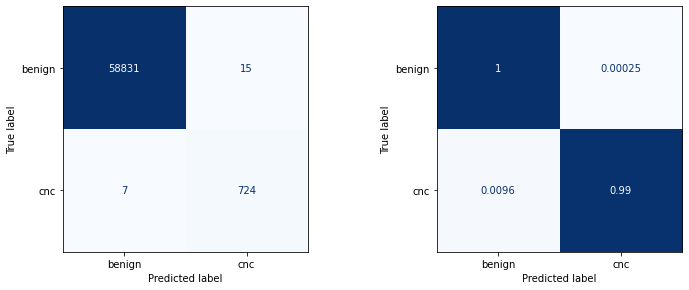

In [78]:
model = results['KNN']['model']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
_ = evaluate_model(model, X_test, y_test, y_pred)

### Decision Tree

ROC AUC: 0.9857381224558266
Accuracy: 0.9891736744045521
Precision: 0.5318518518518518
Recall: 0.9822161422708618
F1 score: 0.6900528592023065


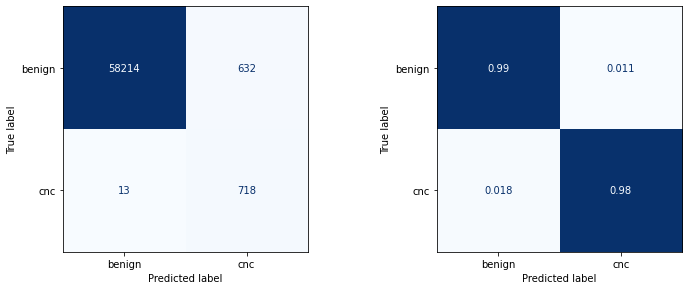

In [59]:
model = results['DecisionTree']['model']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
_ = evaluate_model(model, X_test, y_test, y_pred)

### Logistic Regression

ROC AUC: 0.9892133065634043
Accuracy: 0.9933699246353459
Precision: 0.6521739130434783
Recall: 0.9849521203830369
F1 score: 0.7847411444141689


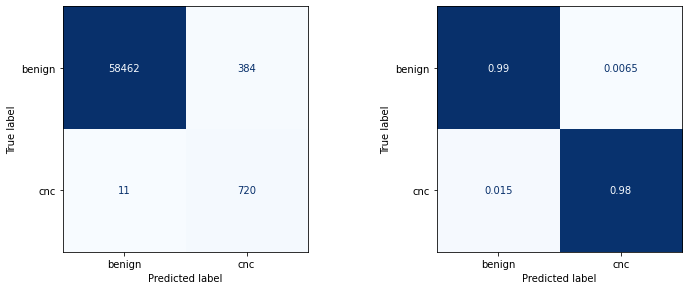

In [60]:
model = results['LogisticRegression']['model']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
_ = evaluate_model(model, X_test, y_test, y_pred)

### Random Forest

ROC AUC: 0.9924675634372786
Accuracy: 0.9997985799889219
Precision: 0.9986130374479889
Recall: 0.9849521203830369
F1 score: 0.9917355371900827


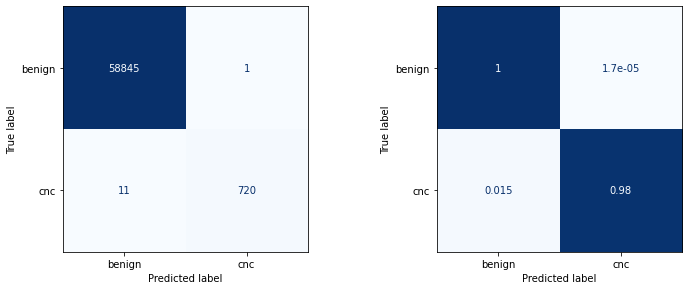

In [72]:
model = results['RandomForest']['model']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
_ = evaluate_model(model, X_test, y_test, y_pred)

### AdaBoost

ROC AUC: 0.9952035415494537
Accuracy: 0.9998657199926146
Precision: 0.9986206896551724
Recall: 0.9904240766073872
F1 score: 0.9945054945054945


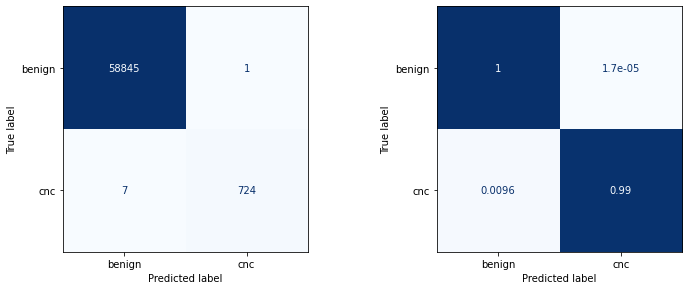

In [108]:
model = results['AdaBoost']['model']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
_ = evaluate_model(model, X_test, y_test, y_pred)